Import, Drive mount and constants

In [ ]:
# ==== Step 1: Mount & unzip dataset ====
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

ZIP_PATH     = '/content/drive/MyDrive/dataset/archive.zip'  # <- your zip
EXTRACT_DIR  = '/content/dataset_extracted'                  # temp extract dir
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extract all files from the zip
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

# Try to auto-detect the dataset root (a folder that contains multiple class subfolders)
import os

IMG_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

def looks_like_class_dir(p):
    # returns True if folder contains at least one image file
    for root, _, files in os.walk(p):
        if any(f.lower().endswith(IMG_EXTS) for f in files):
            return True
    return False

def find_dataset_root(root):
    candidates = []
    for dirpath, dirnames, _ in os.walk(root):
        # If this directory has >=2 subfolders and at least 2 of those look like class dirs
        if len(dirnames) >= 2:
            valid = sum(1 for d in dirnames if looks_like_class_dir(os.path.join(dirpath, d)))
            if valid >= 2:
                candidates.append(dirpath)
    if candidates:
        # choose the shallowest (closest to extracted root)
        return min(candidates, key=len)
    return root

DATA_DIR = find_dataset_root(EXTRACT_DIR)
print('Detected DATA_DIR ->', DATA_DIR)


Mounted at /content/drive
Detected DATA_DIR -> /content/dataset_extracted/realwaste-main/RealWaste


Imports, constants, transforms, datasets & loaders

Using device: cuda
Loading full dataset for splitting...
Found 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train images: 3326
Validation images: 712
Test images: 714


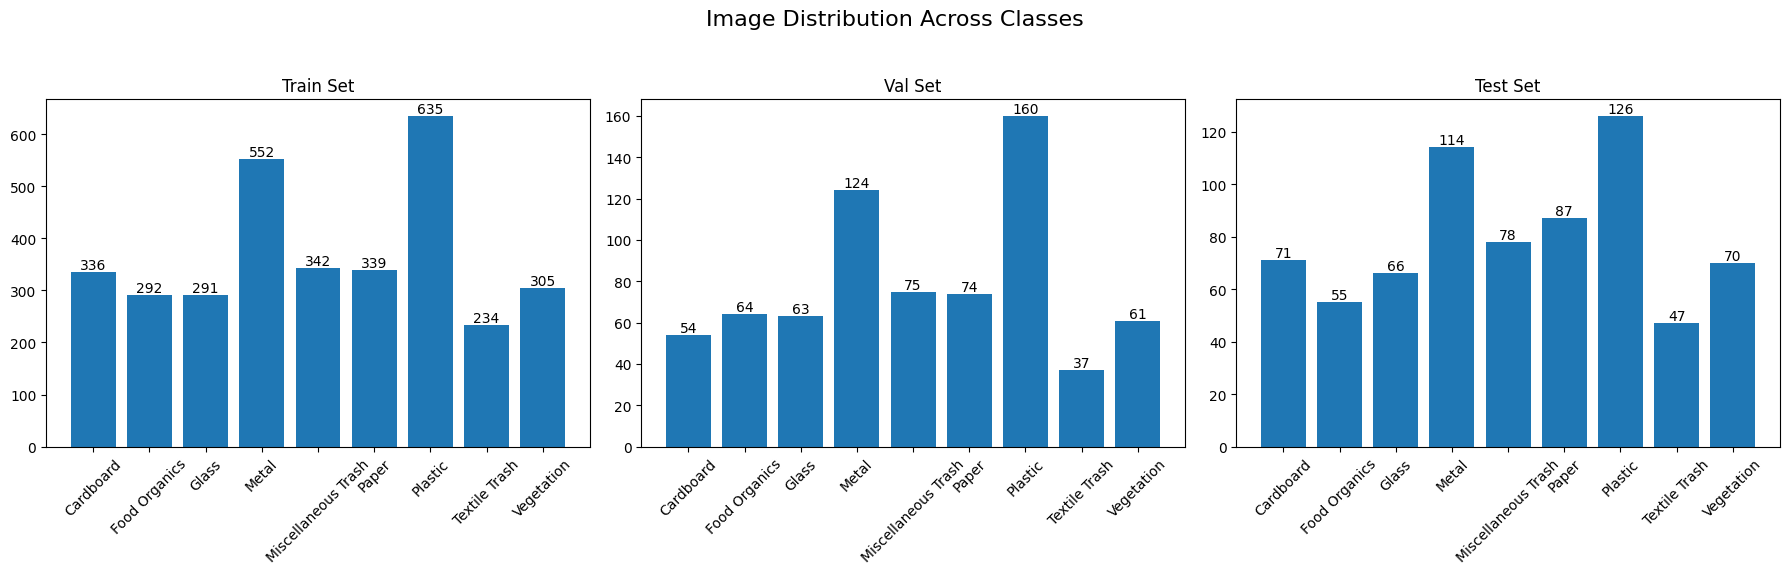

In [ ]:
# ==== Step 2: Imports & data setup ====
import os, cv2, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix

BATCH_SIZE      = 32
NUM_EPOCHS      = 50
LEARNING_RATE   = 1e-3
PATIENCE        = 5
MODEL_SAVE_PATH = 'best_resnet50_waste_classifier_with_attention.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

print("Loading full dataset for splitting...")
full_dataset_for_split   = datasets.ImageFolder(DATA_DIR, data_transforms['val_test'])
full_dataset_for_gradcam = datasets.ImageFolder(DATA_DIR, transforms.ToTensor())

class_names = full_dataset_for_split.classes
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# 70/15/15 split
train_size = int(0.7 * len(full_dataset_for_split))
val_size   = int(0.15 * len(full_dataset_for_split))
test_size  = len(full_dataset_for_split) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset_for_split, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Use augmentation on the training subset only
train_dataset.dataset.transform = data_transforms['train']

image_datasets = {
    'train': train_dataset,
    'val'  : val_dataset,
    'test' : test_dataset
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True,  num_workers=2),
    'val'  : DataLoader(image_datasets['val'],   batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    'test' : DataLoader(image_datasets['test'],  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

print(f"Train images: {len(image_datasets['train'])}")
print(f"Validation images: {len(image_datasets['val'])}")
print(f"Test images: {len(image_datasets['test'])}")

# Visualise data distribution
def plot_data_distribution(dsets, class_names):
    phases = ['train', 'val', 'test']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Image Distribution Across Classes', fontsize=16)
    for i, phase in enumerate(phases):
        ds = dsets[phase]
        targets = [ds.dataset.targets[idx] for idx in ds.indices]
        counts = Counter(targets)
        labels = [class_names[j] for j in sorted(counts.keys())]
        values = [counts[j] for j in sorted(counts.keys())]
        axes[i].bar(labels, values)
        axes[i].set_title(f'{phase.capitalize()} Set')
        axes[i].tick_params(axis='x', rotation=45)
        for idx, v in enumerate(values):
            axes[i].text(idx, v, str(v), ha='center', va='bottom')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_data_distribution(image_datasets, class_names)


Model: ResNet50 + Channel Attention (on layer4 output)

In [ ]:
# ==== Step 3: Define ResNet50 with Channel Attention ====
class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel * 2, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.avg_pool(x).view(b, c)
        max_out = self.max_pool(x).view(b, c)
        out = torch.cat([avg_out, max_out], dim=1)
        attn = self.fc(out).view(b, c, 1, 1)
        return x * attn

class ResNet50WithAttention(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Freeze everything first
        for p in backbone.parameters():
            p.requires_grad = False

        # Unfreeze layer4 for light fine-tuning
        for p in backbone.layer4.parameters():
            p.requires_grad = True

        # Rebuild as a Sequential backbone to tap after layer4
        self.backbone = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu,
            backbone.maxpool,
            backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4
        )

        self.attention = ChannelAttention(channel=2048)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)      # -> [B, 2048, H/32, W/32]
        x = self.attention(x)     # channel attention
        x = self.pool(x)          # -> [B, 2048, 1, 1]
        x = torch.flatten(x, 1)   # -> [B, 2048]
        x = self.fc(x)            # -> [B, num_classes]
        return x

print("Initializing ResNet50 model with Attention...")
model = ResNet50WithAttention(num_classes).to(device)

# Class weights (handle imbalance)
train_targets = [image_datasets['train'].dataset.targets[idx] for idx in image_datasets['train'].indices]
class_counts  = Counter(train_targets)
total_samples = len(train_targets)
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimise only trainable params (layer4 + attention + fc)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)


Initializing ResNet50 model with Attention...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Class weights: tensor([1.0999, 1.2656, 1.2700, 0.6695, 1.0806, 1.0901, 0.5820, 1.5793, 1.2117],
       device='cuda:0')


Training loop with early stopping & best-model save

In [ ]:
# ==== Step 4: Train ====
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, patience=PATIENCE):
    best_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = outputs.max(1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss   += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc  = running_corrects / len(image_datasets[phase])
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss); train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss);   val_accs.append(epoch_acc)

                # Save best by accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), MODEL_SAVE_PATH)
                    print(f"Saved best model (val acc: {best_acc:.4f})")

                # Early stopping on val loss
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping (no val loss improvement for {patience_counter} epochs).")
            break

    print(f"Training complete. Best val acc: {best_acc:.4f}")
    return model, train_losses, train_accs, val_losses, val_accs

print("Starting training...")
model_ft, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer)


Starting training...
Epoch 1/50
----------


Train 1: 100%|██████████| 104/104 [00:24<00:00,  4.20it/s]


Train Loss: 0.9274 Acc: 0.6813


Val 1: 100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


Val Loss: 0.6235 Acc: 0.7711
Saved best model (val acc: 0.7711)
Epoch 2/50
----------


Train 2: 100%|██████████| 104/104 [00:22<00:00,  4.53it/s]


Train Loss: 0.4645 Acc: 0.8295


Val 2: 100%|██████████| 23/23 [00:05<00:00,  4.55it/s]


Val Loss: 0.4982 Acc: 0.8244
Saved best model (val acc: 0.8244)
Epoch 3/50
----------


Train 3: 100%|██████████| 104/104 [00:22<00:00,  4.60it/s]


Train Loss: 0.3622 Acc: 0.8695


Val 3: 100%|██████████| 23/23 [00:06<00:00,  3.50it/s]


Val Loss: 0.4234 Acc: 0.8315
Saved best model (val acc: 0.8315)
Epoch 4/50
----------


Train 4: 100%|██████████| 104/104 [00:22<00:00,  4.53it/s]


Train Loss: 0.2666 Acc: 0.9080


Val 4: 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


Val Loss: 0.5434 Acc: 0.8315
Epoch 5/50
----------


Train 5: 100%|██████████| 104/104 [00:22<00:00,  4.57it/s]


Train Loss: 0.2500 Acc: 0.9176


Val 5: 100%|██████████| 23/23 [00:05<00:00,  4.13it/s]


Val Loss: 0.3829 Acc: 0.8862
Saved best model (val acc: 0.8862)
Epoch 6/50
----------


Train 6: 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


Train Loss: 0.2168 Acc: 0.9224


Val 6: 100%|██████████| 23/23 [00:05<00:00,  4.24it/s]


Val Loss: 0.3522 Acc: 0.8778
Epoch 7/50
----------


Train 7: 100%|██████████| 104/104 [00:22<00:00,  4.55it/s]


Train Loss: 0.1809 Acc: 0.9314


Val 7: 100%|██████████| 23/23 [00:06<00:00,  3.56it/s]


Val Loss: 0.3528 Acc: 0.8778
Epoch 8/50
----------


Train 8: 100%|██████████| 104/104 [00:23<00:00,  4.49it/s]


Train Loss: 0.1715 Acc: 0.9381


Val 8: 100%|██████████| 23/23 [00:04<00:00,  4.87it/s]


Val Loss: 0.4194 Acc: 0.8862
Epoch 9/50
----------


Train 9: 100%|██████████| 104/104 [00:23<00:00,  4.45it/s]


Train Loss: 0.1540 Acc: 0.9465


Val 9: 100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Val Loss: 0.3693 Acc: 0.8834
Epoch 10/50
----------


Train 10: 100%|██████████| 104/104 [00:23<00:00,  4.36it/s]


Train Loss: 0.1470 Acc: 0.9498


Val 10: 100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Val Loss: 0.3823 Acc: 0.9031
Saved best model (val acc: 0.9031)
Epoch 11/50
----------


Train 11: 100%|██████████| 104/104 [00:23<00:00,  4.35it/s]


Train Loss: 0.1395 Acc: 0.9462


Val 11: 100%|██████████| 23/23 [00:04<00:00,  5.66it/s]


Val Loss: 0.3329 Acc: 0.9073
Saved best model (val acc: 0.9073)
Epoch 12/50
----------


Train 12: 100%|██████████| 104/104 [00:25<00:00,  4.15it/s]


Train Loss: 0.1255 Acc: 0.9498


Val 12: 100%|██████████| 23/23 [00:04<00:00,  4.79it/s]


Val Loss: 0.3468 Acc: 0.8919
Epoch 13/50
----------


Train 13: 100%|██████████| 104/104 [00:24<00:00,  4.23it/s]


Train Loss: 0.1271 Acc: 0.9519


Val 13: 100%|██████████| 23/23 [00:04<00:00,  5.64it/s]


Val Loss: 0.4093 Acc: 0.8764
Epoch 14/50
----------


Train 14: 100%|██████████| 104/104 [00:24<00:00,  4.26it/s]


Train Loss: 0.1042 Acc: 0.9672


Val 14: 100%|██████████| 23/23 [00:04<00:00,  5.55it/s]


Val Loss: 0.3232 Acc: 0.8961
Epoch 15/50
----------


Train 15: 100%|██████████| 104/104 [00:22<00:00,  4.71it/s]


Train Loss: 0.1038 Acc: 0.9618


Val 15: 100%|██████████| 23/23 [00:04<00:00,  4.91it/s]


Val Loss: 0.3502 Acc: 0.8919
Epoch 16/50
----------


Train 16: 100%|██████████| 104/104 [00:23<00:00,  4.44it/s]


Train Loss: 0.0960 Acc: 0.9684


Val 16: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


Val Loss: 0.2953 Acc: 0.9129
Saved best model (val acc: 0.9129)
Epoch 17/50
----------


Train 17: 100%|██████████| 104/104 [00:20<00:00,  4.98it/s]


Train Loss: 0.0854 Acc: 0.9693


Val 17: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]


Val Loss: 0.3371 Acc: 0.8947
Epoch 18/50
----------


Train 18: 100%|██████████| 104/104 [00:22<00:00,  4.54it/s]


Train Loss: 0.1079 Acc: 0.9600


Val 18: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


Val Loss: 0.3736 Acc: 0.8806
Epoch 19/50
----------


Train 19: 100%|██████████| 104/104 [00:23<00:00,  4.44it/s]


Train Loss: 0.1080 Acc: 0.9618


Val 19: 100%|██████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.3242 Acc: 0.8820
Epoch 20/50
----------


Train 20: 100%|██████████| 104/104 [00:24<00:00,  4.28it/s]


Train Loss: 0.1044 Acc: 0.9579


Val 20: 100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Val Loss: 0.3366 Acc: 0.8947
Epoch 21/50
----------


Train 21: 100%|██████████| 104/104 [00:24<00:00,  4.25it/s]


Train Loss: 0.0818 Acc: 0.9687


Val 21: 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]

Val Loss: 0.3508 Acc: 0.9073
Early stopping (no val loss improvement for 5 epochs).
Training complete. Best val acc: 0.9129


Plot Training History

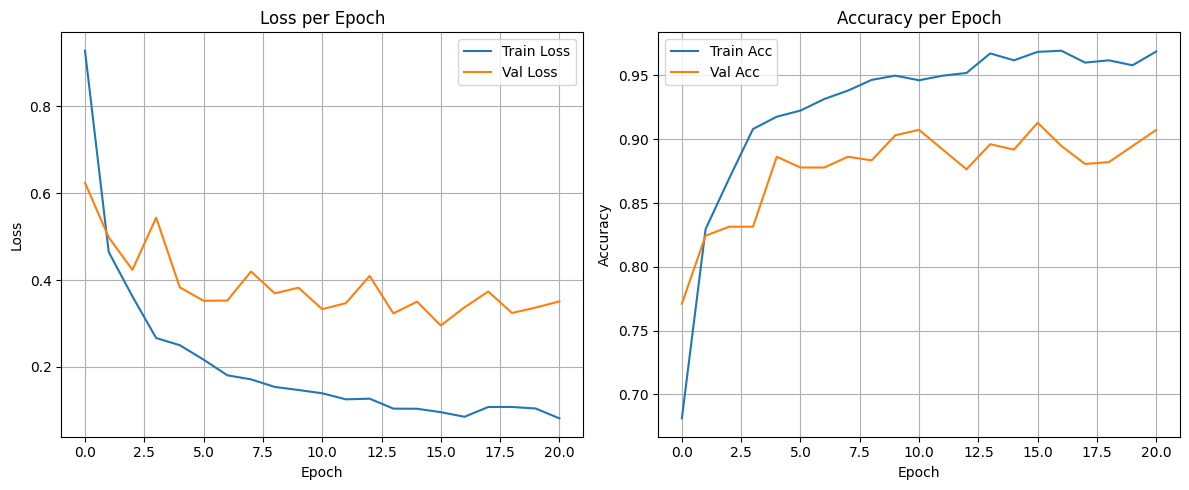

In [ ]:
# ==== Step 5: Plots ====
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title('Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs,   label='Val Acc')
plt.title('Accuracy per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()


Test evaluation, report & confusion matrix

Testing: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]


Test Accuracy: 0.9006

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.89      0.92      0.90        71
      Food Organics       0.96      0.93      0.94        55
              Glass       0.97      0.91      0.94        66
              Metal       0.97      0.83      0.90       114
Miscellaneous Trash       0.82      0.82      0.82        78
              Paper       0.95      0.93      0.94        87
            Plastic       0.80      0.91      0.86       126
      Textile Trash       0.88      0.91      0.90        47
         Vegetation       0.95      0.99      0.97        70

           accuracy                           0.90       714
          macro avg       0.91      0.91      0.91       714
       weighted avg       0.90      0.90      0.90       714



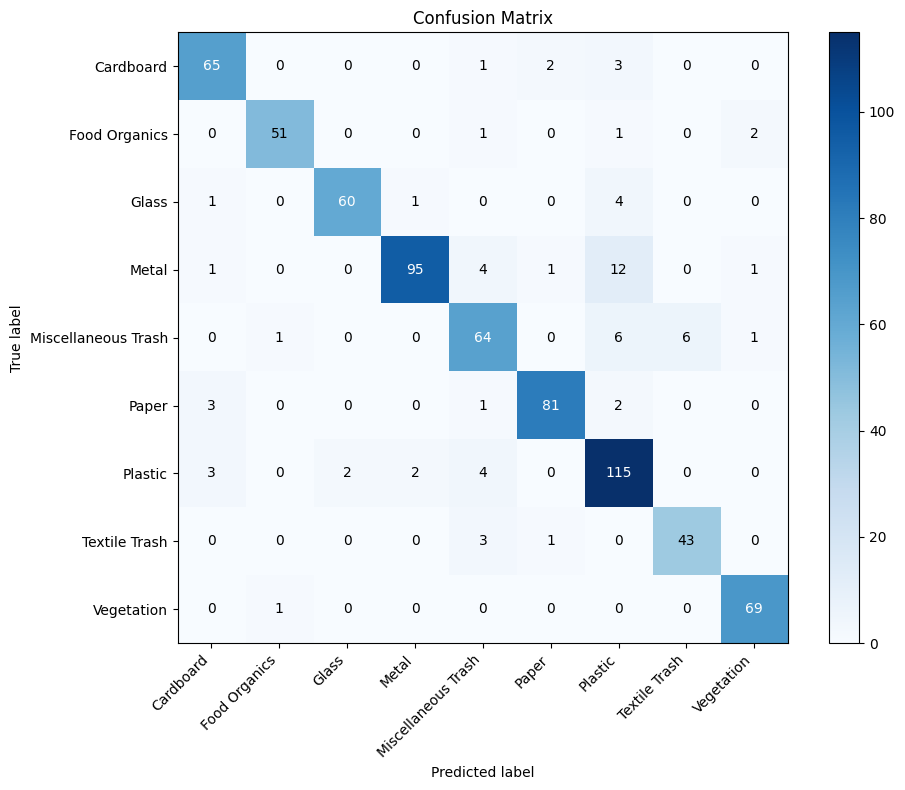

In [ ]:
# ==== Step 6: Evaluate on Test Set ====
# Load best checkpoint
model_ft.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model_ft.eval()

running_corrects, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['test'], desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, preds = outputs.max(1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

test_acc = running_corrects / total
print(f"Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.ylabel('True label'); plt.xlabel('Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout(); plt.show()


Grad-CAM for ResNet50 (hook on layer4 output)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


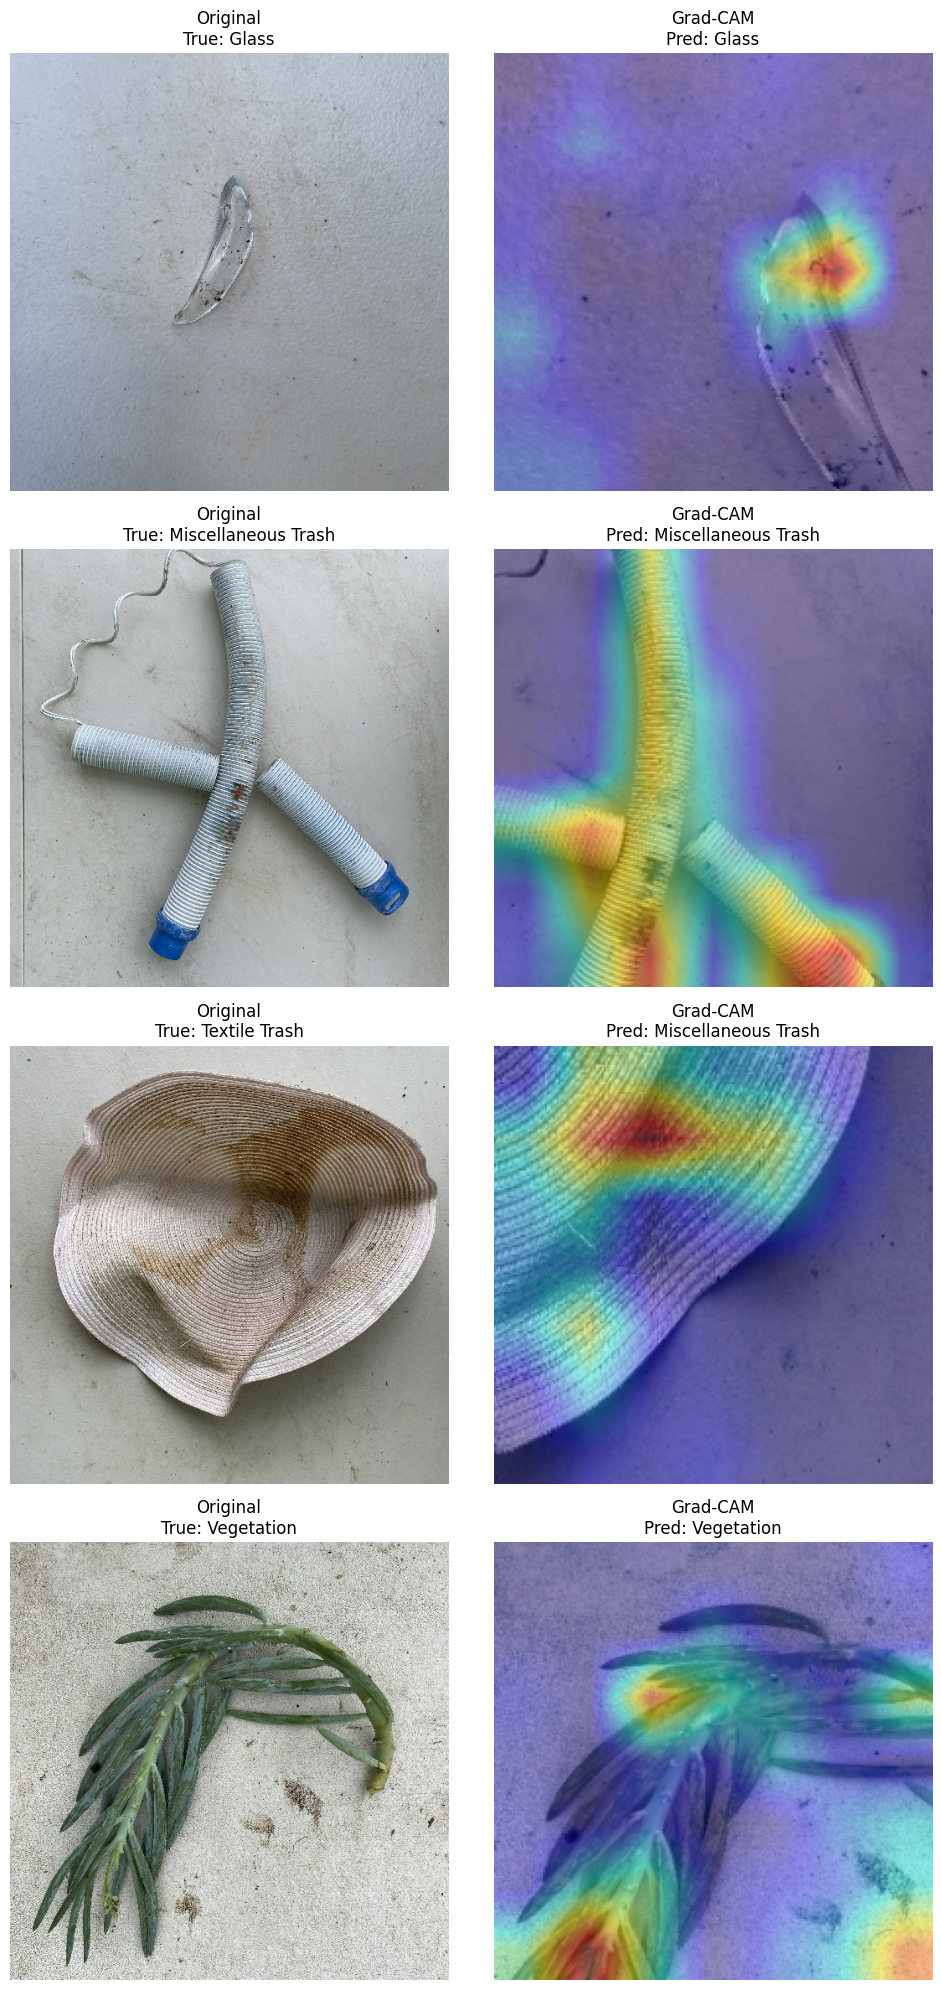

Done.


In [ ]:
# ==== Step 7: Grad-CAM (ResNet50) ====
def generate_gradcam(model, input_image, target_layer, device):
    model.eval()
    input_image = input_image.unsqueeze(0).to(device)

    activations = []
    gradients   = []

    def fwd_hook(module, inp, out):
        out.retain_grad()
        activations.append(out)

    def bwd_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    model.zero_grad()
    output = model(input_image)
    _, pred = output.max(1)
    score = output[:, pred.item()]
    score.backward(retain_graph=True)

    h1.remove(); h2.remove()

    # Compute weights and heatmap
    A = activations[0]        # [B, C, H, W]
    G = gradients[0]          # [B, C, H, W]
    weights = torch.mean(G, dim=(2,3), keepdim=True)  # GAP over H,W
    heatmap = torch.relu(torch.sum(weights * A, dim=1)).squeeze()  # [H, W]

    # Resize to input spatial size (224x224)
    heatmap = cv2.resize(heatmap.detach().cpu().numpy(),
                         (input_image.shape[3], input_image.shape[2]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    x = input_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)
    overlay = cv2.addWeighted(np.uint8(x*255), 0.6, heatmap, 0.4, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay, pred.item()

# Build a tiny subset to visualise
num_samples = 4
test_subset        = Subset(image_datasets['test'], range(min(num_samples, len(image_datasets['test']))))
test_loader_cam    = DataLoader(test_subset, batch_size=1, shuffle=False)

# We also need original (unnormalised) for display:
test_dataset_orig  = datasets.ImageFolder(DATA_DIR, transforms.ToTensor())
test_subset_orig   = Subset(test_dataset_orig, [image_datasets['test'].indices[i] for i in range(len(test_subset))])
test_loader_orig   = DataLoader(test_subset_orig, batch_size=1, shuffle=False)

# Target layer = the layer4 block output in our Sequential backbone
target_layer = model_ft.backbone[7]  # layer4 (Sequential); hooking here captures final conv output

import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(test_subset), 2, figsize=(10, 5*len(test_subset)))
if len(test_subset) == 1:
    axes = np.array([axes])  # ensure 2D

for i, ((orig_img, _), (inp_tensor, _)) in enumerate(zip(test_loader_orig, test_loader_cam)):
    cam_img, pred_idx = generate_gradcam(model_ft, inp_tensor.squeeze(0), target_layer, device)
    axes[i,0].imshow(np.transpose(orig_img.squeeze(0).numpy(), (1,2,0)))
    true_idx = full_dataset_for_split.targets[image_datasets['test'].indices[i]]
    axes[i,0].set_title(f'Original\nTrue: {class_names[true_idx]}'); axes[i,0].axis('off')

    axes[i,1].imshow(cam_img)
    axes[i,1].set_title(f'Grad-CAM\nPred: {class_names[pred_idx]}'); axes[i,1].axis('off')

plt.tight_layout(); plt.show()

print("Done.")


In [ ]:
# === Save model/checkpoints to Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, time, torch

# Where to store in Drive
DRIVE_DIR = '/content/drive/MyDrive/colab_models'
os.makedirs(DRIVE_DIR, exist_ok=True)

# 1) If you already saved locally during training (e.g., MODEL_SAVE_PATH):
#    Copy that file into Drive
LOCAL_CKPT = MODEL_SAVE_PATH  # e.g. 'best_resnet50_waste_classifier_with_attention.pth'
DEST_COPY = os.path.join(DRIVE_DIR, os.path.basename(LOCAL_CKPT))
if os.path.exists(LOCAL_CKPT):
    shutil.copyfile(LOCAL_CKPT, DEST_COPY)
    print("Copied existing checkpoint to:", DEST_COPY)
else:
    print("Local checkpoint not found at", LOCAL_CKPT)

# 2) Save a fresh state_dict directly to Drive
STATE_DICT_PATH = os.path.join(DRIVE_DIR, 'resnet50_attn_state_dict.pth')
torch.save(model_ft.state_dict(), STATE_DICT_PATH)
print("Saved state_dict to:", STATE_DICT_PATH)

# (Optional) 3) Save a full model (architecture + weights) — larger, less portable
FULL_MODEL_PATH = os.path.join(DRIVE_DIR, 'resnet50_attn_full_model.pth')
torch.save(model_ft, FULL_MODEL_PATH)
print("Saved full model to:", FULL_MODEL_PATH)

# (Optional) 4) Save a checkpoint with metadata (recommended)
CHECKPOINT_PATH = os.path.join(DRIVE_DIR, 'resnet50_attn_checkpoint.pt')
checkpoint = {
    'state_dict': model_ft.state_dict(),
    'class_names': class_names,
    'num_classes': len(class_names),
    'saved_at': time.strftime('%Y-%m-%d %H:%M:%S'),
}
torch.save(checkpoint, CHECKPOINT_PATH)
print("Saved checkpoint with metadata to:", CHECKPOINT_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied existing checkpoint to: /content/drive/MyDrive/colab_models/best_resnet50_waste_classifier_with_attention.pth
Saved state_dict to: /content/drive/MyDrive/colab_models/resnet50_attn_state_dict.pth
Saved full model to: /content/drive/MyDrive/colab_models/resnet50_attn_full_model.pth
Saved checkpoint with metadata to: /content/drive/MyDrive/colab_models/resnet50_attn_checkpoint.pt
